In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt
 
df = pd.read_csv('C:/Users/Desktop/time feature/B0005_time.csv',encoding= 'CP949') 
df

,Cycle,VMT,CMT,TMT,capacity,SOH,IC
0,1,3241.797,3324.484,3447.609,1.856487,92.824371,5.608811
1,2,3241.797,3324.484,3447.609,1.846327,92.316362,5.608811
2,3,3238.719,3321.344,3419.156,1.835349,91.767460,5.629508
3,4,3229.203,3299.828,3421.593,1.835263,91.763126,5.244733
4,5,3228.218,3298.718,3395.125,1.834646,91.732275,5.391958
...,...,...,...,...,...,...,...
163,164,1560.609,1620.328,1937.375,1.293464,64.673181,2.854319
164,165,1556.907,1611.204,1963.141,1.288003,64.400170,2.843833
165,166,1544.562,1601.547,1945.328,1.287453,64.372626,2.855158
166,167,1534.344,1591.234,1916.609,1.309015,65.450768,2.845511


In [2]:
#타겟 제외 스케일링 
scaler = MinMaxScaler()

df[['VMT','CMT','TMT','IC']] = scaler.fit_transform(df[['VMT','CMT','TMT','IC']])

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
#넘파이 배열로 변경 
x = df[['VMT','CMT','TMT','IC']].values
y = df['SOH'].values
 
#시퀀스 데이터 생성 
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])
    
  #gpu용 텐서로 변환 
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [5]:
split = 163
sequence_length=5
x_seq, y_seq = seq_data(x, y, sequence_length)
 
#순서대로 split 개수만큼 학습, 나머지는 평가 
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
 
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
 
print(x_train_seq.shape, y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

print(x_seq)

C:\Users\ryugn123\AppData\Local\Temp\ipykernel_4060\241166647.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([163, 5, 4]) torch.Size([163, 1])
torch.Size([0, 5, 4]) torch.Size([0, 1])
tensor([[[0.9673, 0.9709, 0.9780, 0.9251],
         [0.9673, 0.9709, 0.9780, 0.9251],
         [0.9655, 0.9692, 0.9599, 0.9318],
         [0.9601, 0.9571, 0.9615, 0.8074],
         [0.9596, 0.9565, 0.9446, 0.8550]],

        [[0.9673, 0.9709, 0.9780, 0.9251],
         [0.9655, 0.9692, 0.9599, 0.9318],
         [0.9601, 0.9571, 0.9615, 0.8074],
         [0.9596, 0.9565, 0.9446, 0.8550],
         [0.9603, 0.9574, 0.9617, 0.8526]],

        [[0.9655, 0.9692, 0.9599, 0.9318],
         [0.9601, 0.9571, 0.9615, 0.8074],
         [0.9596, 0.9565, 0.9446, 0.8550],
         [0.9603, 0.9574, 0.9617, 0.8526],
         [0.9615, 0.9652, 0.9714, 0.8589]],

        ...,

        [[0.0261, 0.0257, 0.0118, 0.0347],
         [0.0260, 0.0271, 0.0359, 0.0336],
         [0.0255, 0.0267, 0.0253, 0.1075],
         [0.0173, 0.0200, 0.0159, 0.0343],
         [0.0152, 0.0149, 0.0323, 0.0309]],

        [[0.0260, 0.0271, 0.0359

In [6]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
 
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

In [7]:
#기본 하이퍼 파라미터 설정 
input_size = x_seq.size(2) 
num_layers = 1
hidden_size = 100

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device 
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)
 
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) 
    out, (hn,cn)= self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [8]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

criterion = nn.MSELoss()
num_epochs = 500
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_graph = []
n = len(train_loader)
 
for epoch in range(num_epochs):
  running_loss = 0
 
  for data in train_loader:
    seq, target = data #배치 데이터 
    out = model(seq) #출력값 계산 
    loss = criterion(out, target) #손실함수 계산 
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()
 
  loss_graph.append(running_loss/n)
  if epoch % 100==0:
      print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 6005.2072
[epoch : 100] loss: 6.0067
[epoch : 200] loss: 4.0440
[epoch : 300] loss: 1.8317
[epoch : 400] loss: 1.2341


In [9]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=batch_size, shuffle=False)
 
with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

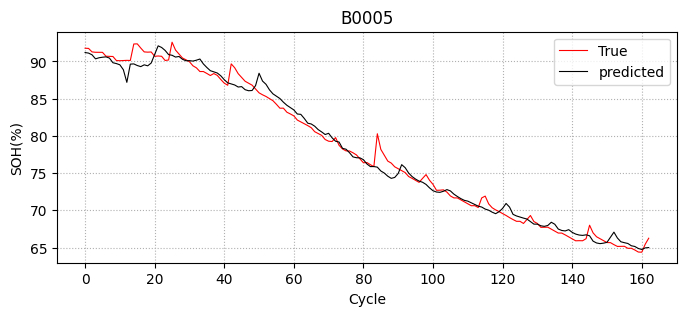

MAE :  0.8358
RMSE : 1.0916


In [10]:
plt.figure(figsize=(8,3))

plt.plot(df['SOH'][sequence_length:].values,linewidth=0.8, c='red')
plt.plot(pred,linewidth=0.8, c='black')

plt.grid(linestyle=':')

plt.title('B0005')
plt.xlabel('Cycle')
plt.ylabel('SOH(%)')

plt.legend(['True','predicted'])
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RMSE = mean_squared_error(pred, df['SOH'][sequence_length:].values, squared=False)
MAE = mean_absolute_error(pred, df['SOH'][sequence_length:].values)

print('MAE : {: .4f}'.format(MAE) )
print('RMSE : {:.4f}'.format(RMSE) )

In [11]:
torch.save(model, "LSTM().pt")